In [140]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import Data_for_bp as dfb

In [141]:
df = pd.read_pickle('Data for Practicum 2/ticks_2019.pkl')

In [142]:
time_deltas = df.index.to_series().diff()

In [143]:
def tick_data_describe(df):
    time_deltas = df.index.to_series().diff()
    summary_data = {
        'Description': [
            'Number of ticks',
            'Mean time between ticks',
            'Median time between ticks',
            'Max time between ticks',
            'Min time between ticks',
            'Ticks with time delta > 10 minutes',
            'Ticks with time delta > 60 seconds',
            'Ticks with time delta > 1 second',
            'Ticks with time delta > 0.1 seconds',
            'Ticks with time delta < 0.1 seconds'
        ],
        'Value': [
            len(df),
            time_deltas.mean(),
            time_deltas.median(),
            time_deltas.max(),
            time_deltas.min(),
            len(time_deltas[time_deltas > pd.Timedelta(minutes=10)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=60)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=1)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=0.1)]),
            len(time_deltas[time_deltas < pd.Timedelta(seconds=0.1)])
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    fig, ax = plt.subplots(figsize=(10, 3))  # set the size
    ax.axis('off')
    ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc = 'center',loc='center')
    plt.show()


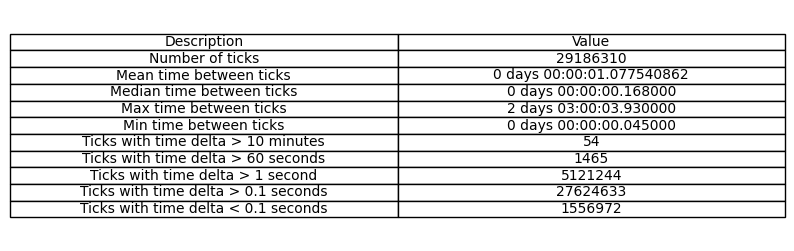

In [144]:
tick_data_describe(df)

In [145]:
ohlc = dfb.tick_to_ohlc(df, '1D')

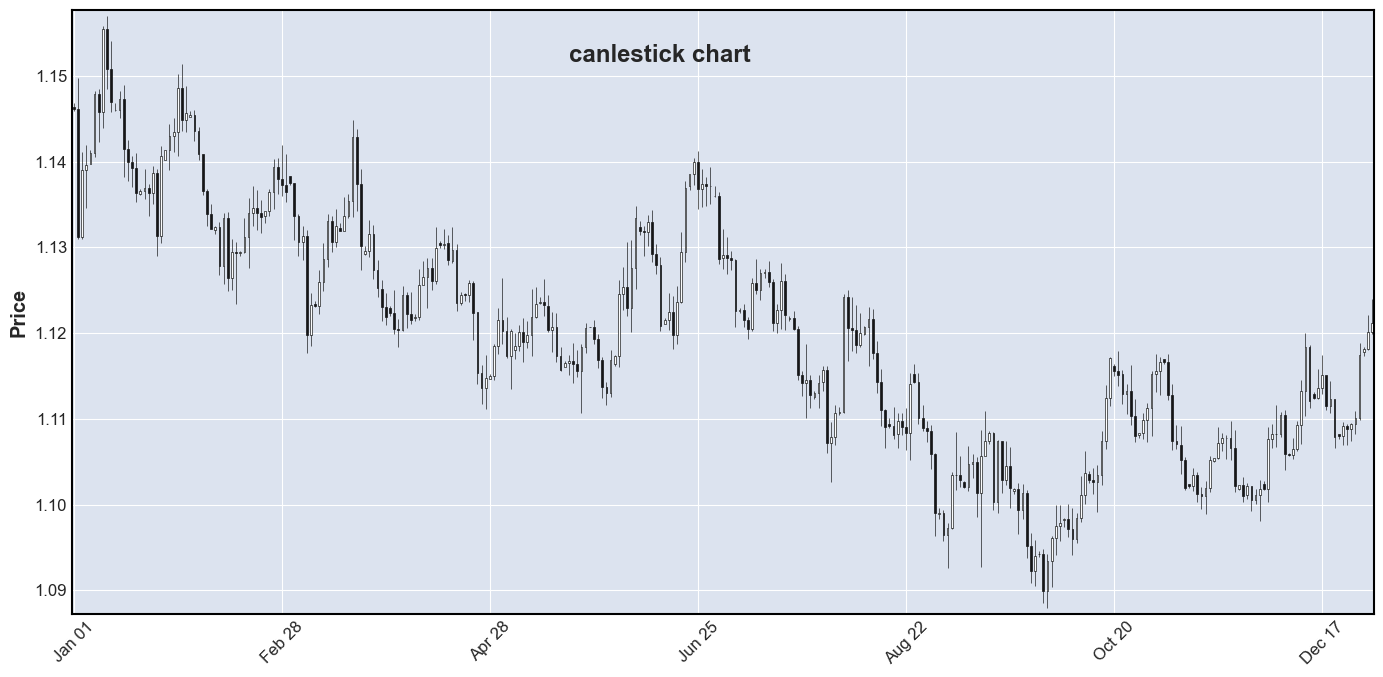

In [146]:
dfb.plot_data(ohlc)

In [147]:
def ohlc_stats(ohlc):
    ohlc['returns'] = ohlc['close'].pct_change()
    ohlc['daily_returns'] = (ohlc['close']-ohlc['open'])/ohlc['open']
    daily_volatility = ohlc['returns'].std()
    buy_and_hold_return = (ohlc['returns']+1).prod()
    mean_return = ohlc['returns'].mean()
    

In [148]:
def ohlc_stats(ohlc):
    ohlc['returns'] = ohlc['close'].pct_change()
    ohlc['daily_returns'] = (ohlc['close']-ohlc['open'])/ohlc['open']
    fig,axs = plt.subplots(3,1,figsize=(10,10))
    axs[0].plot(ohlc['returns'])
    axs[1].hist(ohlc['returns'],bins=20)

    daily_volatility = ohlc['returns'].std()*np.sqrt(252)*100
    buy_and_hold_return = ((ohlc['returns']+1).prod() - 1)*100  # Adjusting to get the total return
    mean_return = ohlc['returns'].mean()*100

    stats_data = {
        'Description': [
            'Daily Volatility',
            'Buy and Hold Return',
            'Mean Return'
        ],
        'Value': [
            daily_volatility,
            buy_and_hold_return,
            mean_return
        ]
    }
    
    stats_df = pd.DataFrame(stats_data)
    axs[2].axis('off')
    axs[2].table(cellText=stats_df.values, colLabels=stats_df.columns, cellLoc = 'center',loc='center')
    fig.tight_layout()
    plt.show()


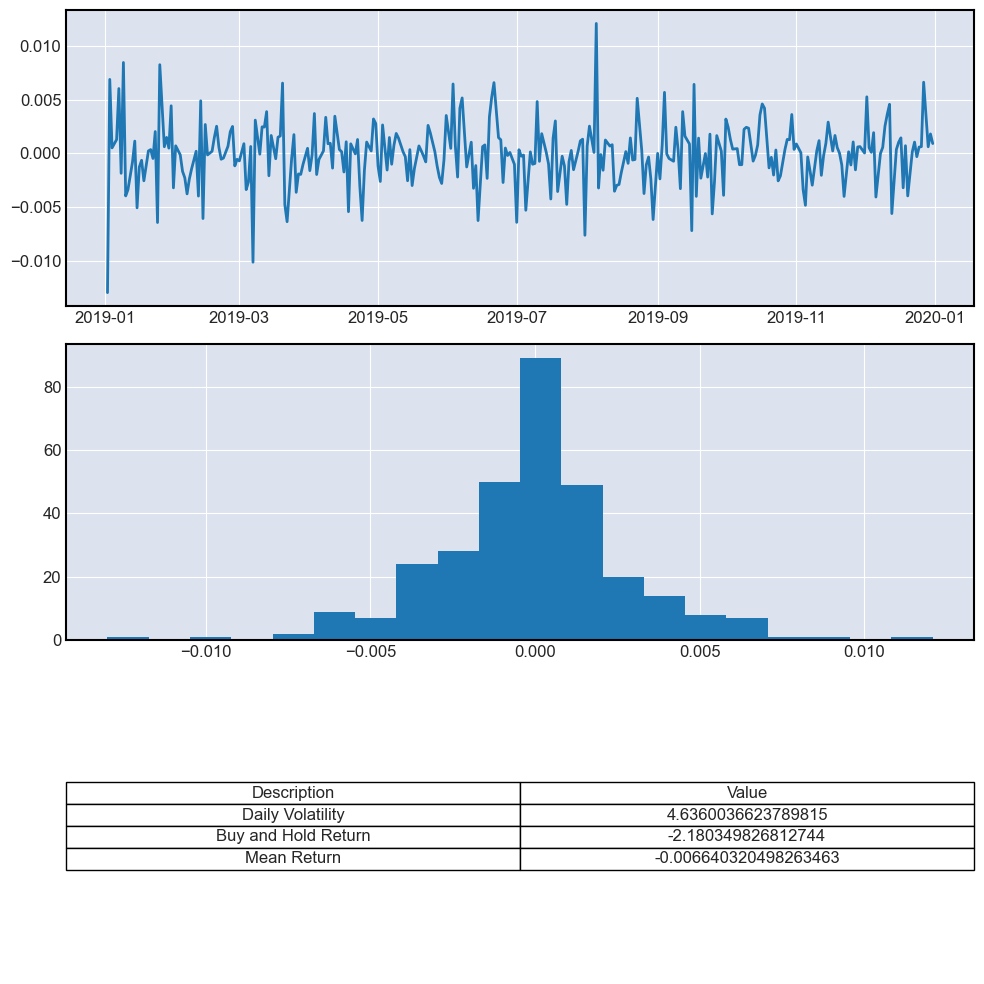

In [149]:
ohlc_stats(ohlc)

In [150]:
def data_analysis_for_bp(tick_data_file):
    df = pd.read_pickle(tick_data_file)
    tick_data_describe(df)
    ohlc = dfb.tick_to_ohlc(df, '1D')
    dfb.plot_data(ohlc)
    ohlc_stats(ohlc)

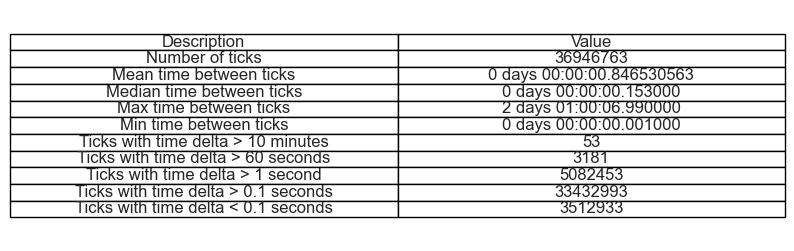

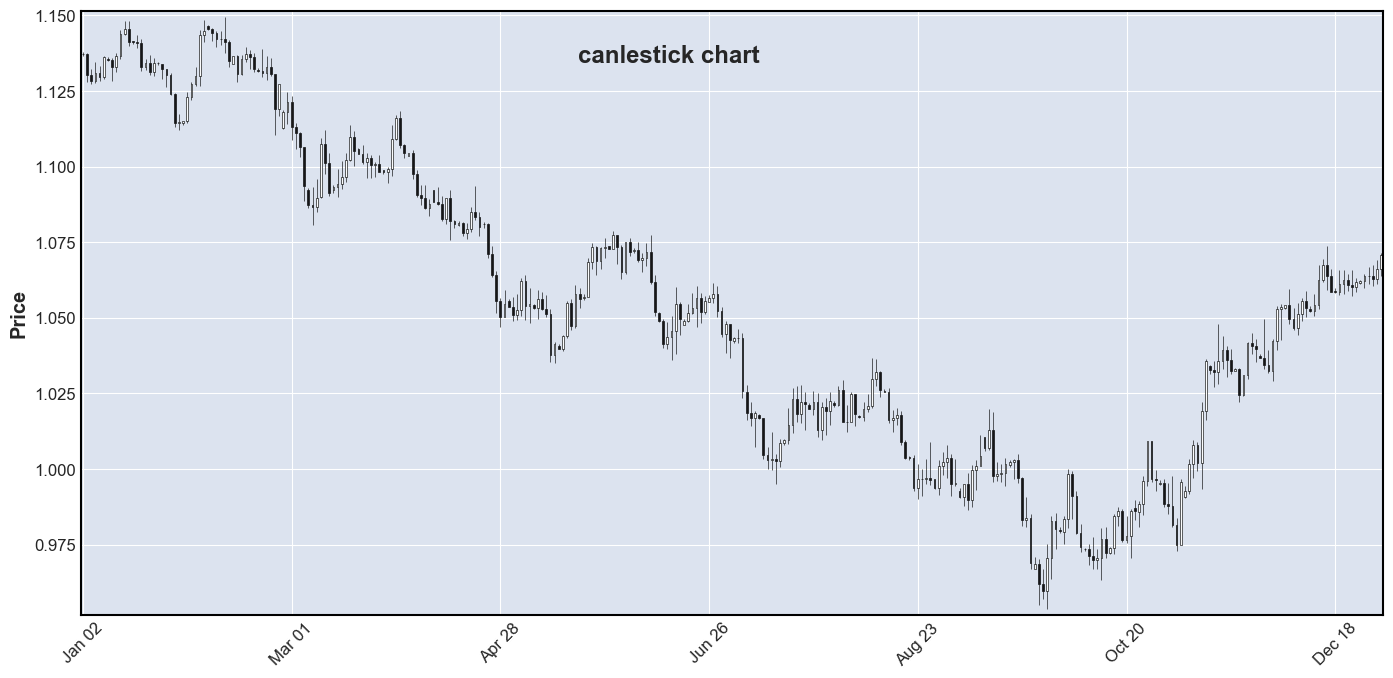

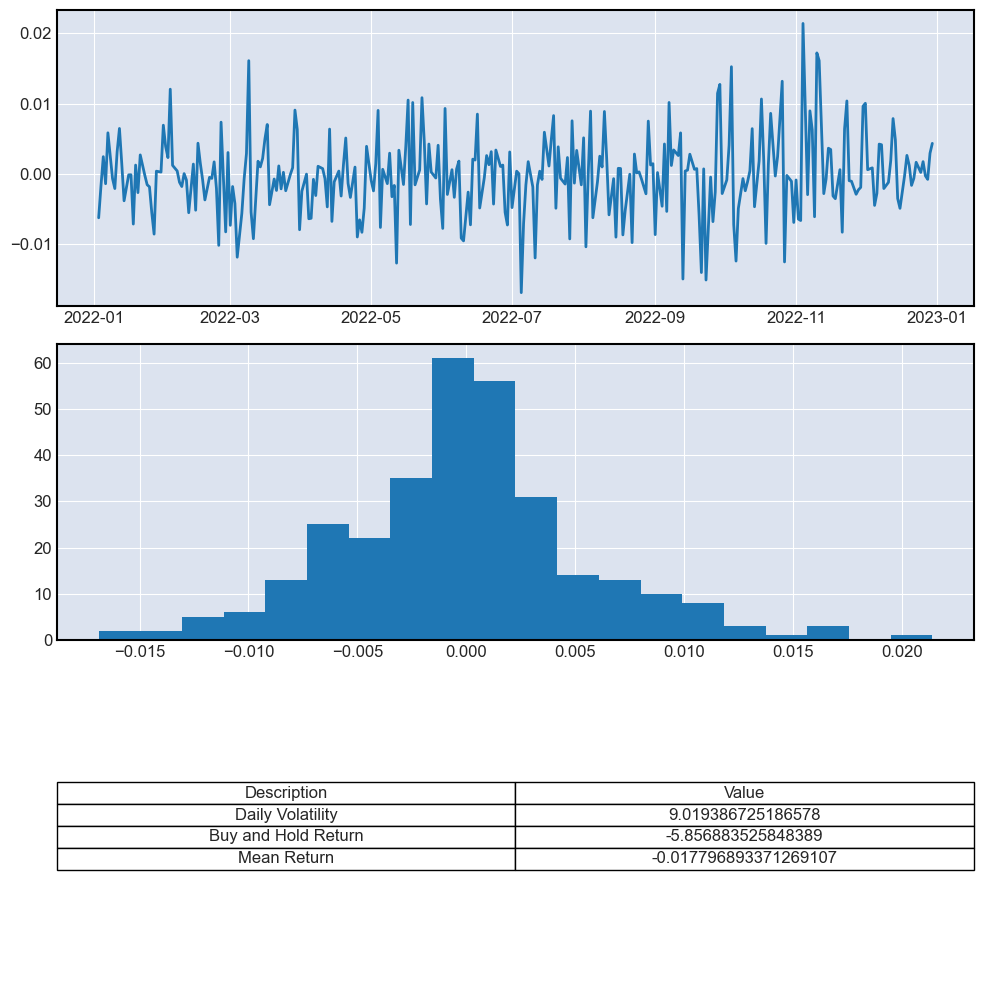

In [151]:
data_analysis_for_bp('Data for Practicum 2/ticks_2022.pkl')

## Ladder strategy data engineering and strategy visualisation

In [152]:
def ladderize_open(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    ladderized_data = [tick_data.iloc[0]]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price
    ladderized_data[-1]=tick_data.iloc[-1]
    return pd.Series(ladderized_data, index=tick_data.index)

In [153]:
def ladderize_absolute(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    # Initialize ladder at the nearest rounded price level based on grid size
    ladderized_data = [(tick_data.iloc[0] / grid_size).round() * grid_size]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price
    ladderized_data[-1]=tick_data.iloc[-1]
    return pd.Series(ladderized_data, index=tick_data.index)

In [154]:
def plot_colored_ladder(ladderized_data):
    for i in range(1, len(ladderized_data)):
        if ladderized_data[i] > ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='red')
        elif ladderized_data[i] < ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='green')
        else:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='blue')  # Neutral color for no change

In [155]:

def plot_ladderized(start_date, end_date, grid_size=0.0005, ladderize_function=ladderize_open):
    # Load the tick data
    tick_data = dfb.get_tick_data(start_date,end_date)['EURUSD.mid']

    ladderized_data = ladderize_function(tick_data, grid_size)

    # Plot the results
    plt.figure(figsize=(15,6))
    plt.plot(tick_data, label='Tick Data',alpha=0.5)
    plot_colored_ladder(ladderized_data)
    # plt.plot(ladderized_data, label='Ladderized Data', linestyle='--')
    plt.title('Ladder Strategy Visualization for date range: {} to {}'.format(start_date, end_date))
    plt.legend()
    plt.show()



2023-09-16 13:26:40,474 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-16 13:26:40,477 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-16 13:26:40,480 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-02 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/02/00h_ticks.bi5
2023-09-16 13:26:45,030 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-03 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/03/00h_ticks.bi5
2023-09-16 13:26:50,289 - findatapy.market.datavendorweb - INFO - Completed request from Dukascopy
2023-09-16 13:26:50,297 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_858__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_... to Redis: Error 61 connecting to 127.0.0.1:6379. Connection refused.


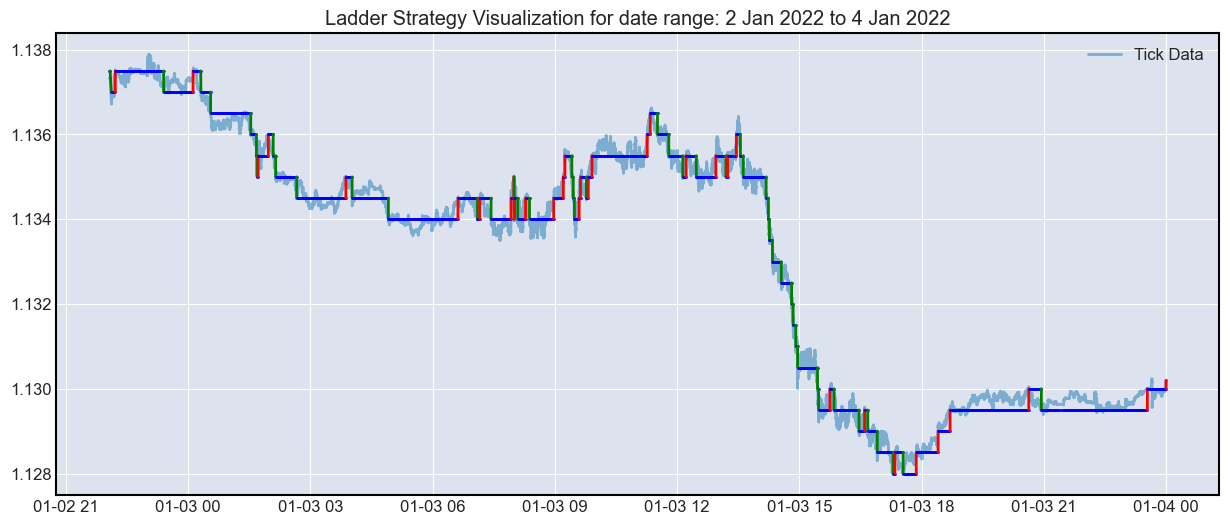

In [312]:
plot_ladderized('2 Jan 2022','4 Jan 2022',grid_size=0.0005,ladderize_function=ladderize_absolute)

In [357]:
tick_data = dfb.get_tick_data('17 Aug 2023','18 Aug 2023')['EURUSD.mid']
ladderized_data = ladderize_absolute(tick_data, grid_size=0.0005)

2023-09-16 13:46:11,321 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-16 13:46:11,322 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD


2023-09-16 13:46:11,324 - findatapy.market.datavendorweb - INFO - Downloading... 2023-08-17 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2023/07/17/00h_ticks.bi5
2023-09-16 13:46:16,686 - findatapy.market.datavendorweb - INFO - Completed request from Dukascopy
2023-09-16 13:46:16,692 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_858__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_... to Redis: Error 61 connecting to 127.0.0.1:6379. Connection refused.


In [358]:
def filter_jumps(ladderized_data):
    """
    Filters ladderized data to keep only the changes in price.

    :param ladderized_data: A pandas Series of ladderized data.
    :return: A pandas Series containing only the data points where there's a change.
    """
    # Calculate the difference between consecutive ladderized data points
    diff = ladderized_data.diff()

    # Filter where the difference is non-zero and include the first data point
    jumps = ladderized_data[diff != 0.0]
    jumps = pd.concat([ladderized_data.iloc[:1], jumps])

    return jumps


In [359]:
def aggregate_differences(jumps,lot_size=1):
    """
    Aggregate the position for buy/sell signals.

    :param jumps: A pandas Series of ladderized data filtered for jumps.
    :return: A pandas Series representing the aggregated position.
    """
    aggregated_position = [0]  # starting from 0
    position = 0
    previous_value = jumps.values[0]
    
    for value in jumps.values[1:]:
        if value > previous_value:
            position -= lot_size  # selling one lot
        else:
            position += lot_size  # buying one lot
        aggregated_position.append(position)
        previous_value = value
    
    return pd.Series(aggregated_position, index=jumps.index)


In [360]:
def plot_jumps(ladderized_data):
    jumps = filter_jumps(ladderized_data)
    aggregated_diff = aggregate_differences(jumps)
    fig,axs = plt.subplots(2,1,figsize=(10,10))
    # Plotting the jumps
    axs[0].plot(jumps.values, label='binomial jumps', linestyle='--', alpha=0.7)
    axs[0].set_title('ladder with jumps')
    # Adding colored points for up and down movements
    previous_value = jumps.values[0]
    for idx, value in enumerate(jumps.values[1:], 1):
        if value > previous_value:
            axs[0].plot(idx, value, 'ro')  # Red point for upward movement
        elif value < previous_value:
            axs[0].plot(idx, value, 'go')  # Blue point for downward movement
        else:
            axs[0].plot(idx, value, 'bo')
        previous_value = value
    axs[0].legend()
    # Plotting the aggregated differences
    axs[1].plot(aggregated_diff.values, label='aggregated difference', linestyle='-', color='purple', alpha=0.8)
    axs[1].legend()
    axs[1].set_title('market depth')
    plt.show()

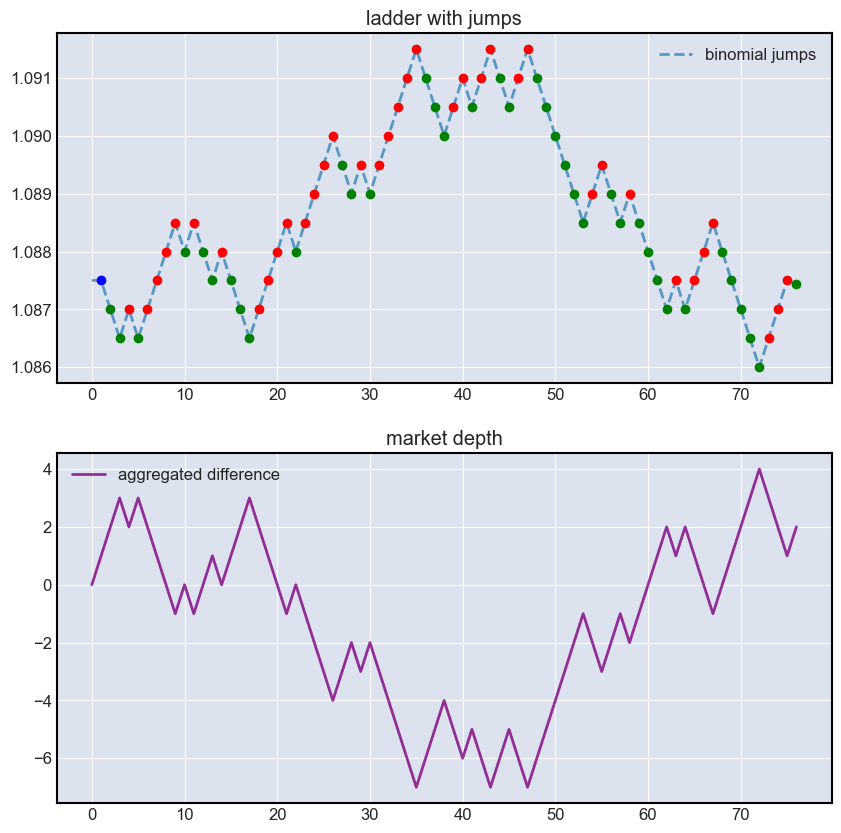

In [361]:
plot_jumps(ladderized_data)

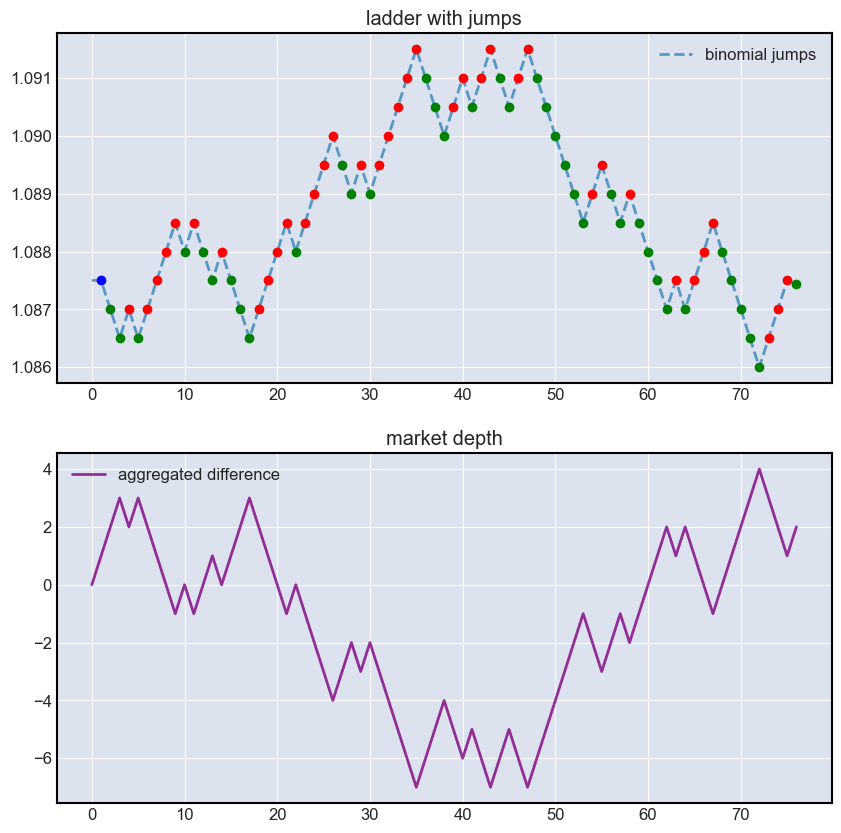

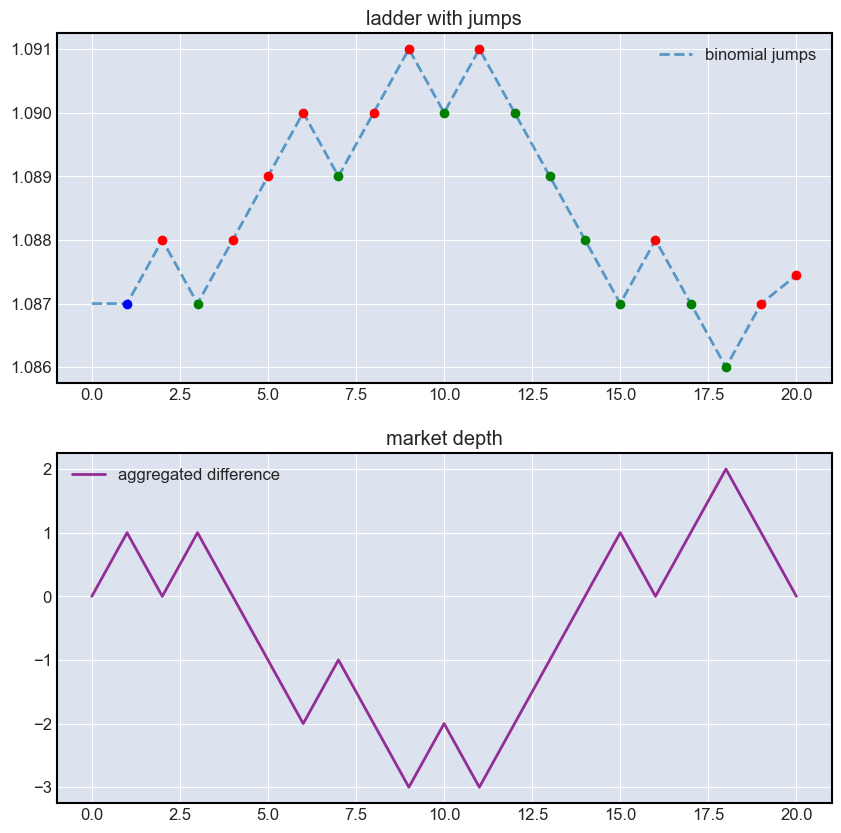

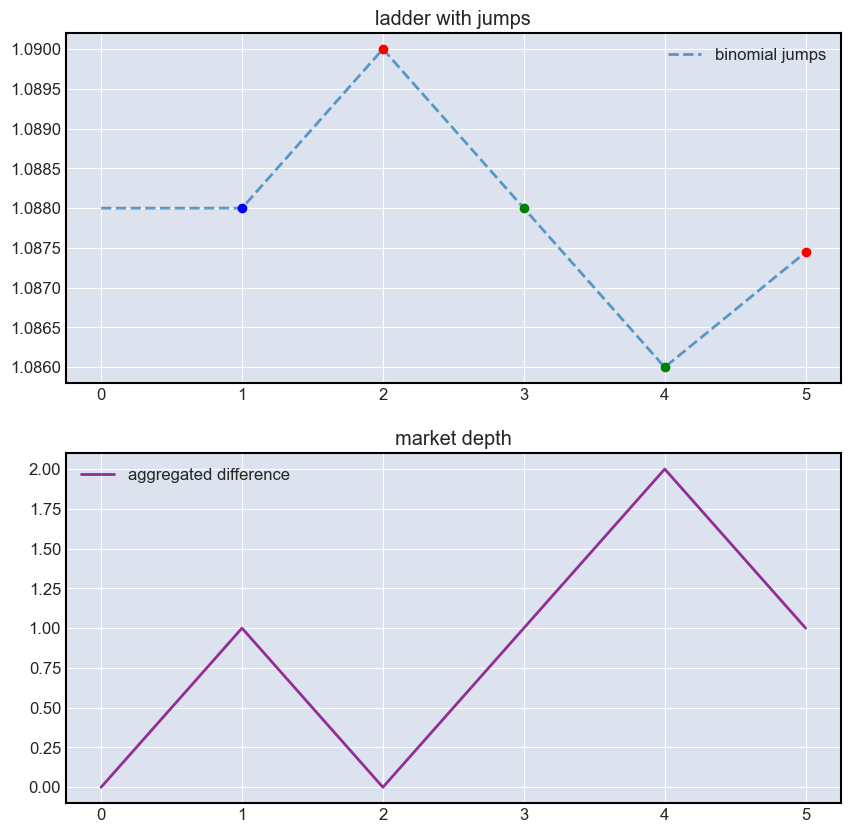

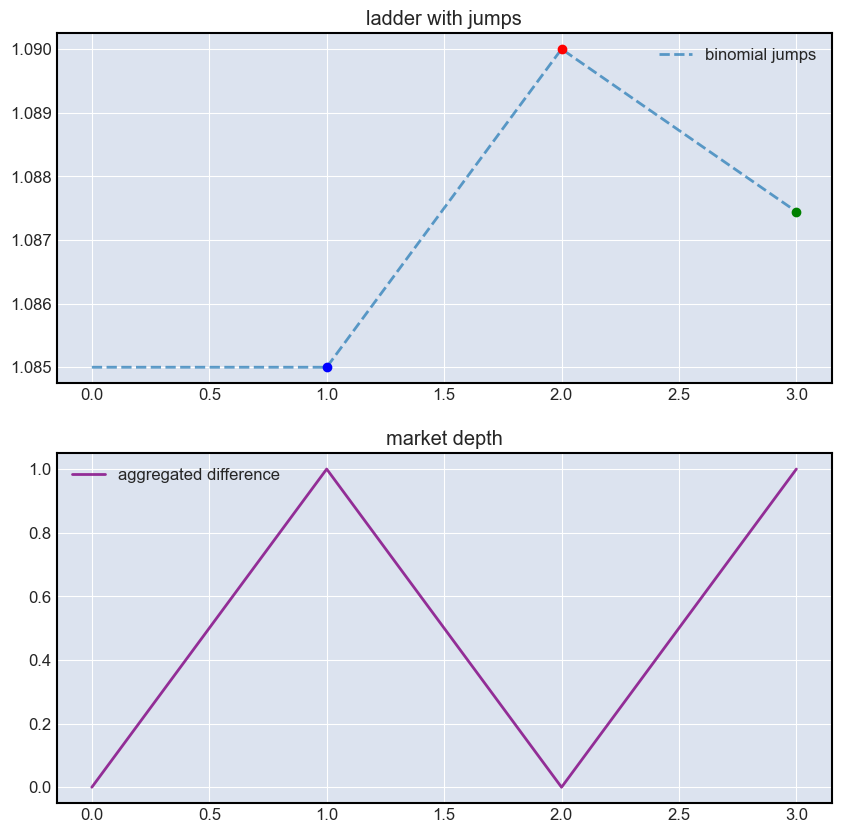

In [362]:
for grid_sizing in [0.0005, 0.001, 0.002, 0.005]:
    ladderised_data = ladderize_absolute(tick_data, grid_size=grid_sizing)
    plot_jumps(ladderised_data)

In [363]:
def velocity(data):
    return data.diff()/data

def acceleration(data):
    return data.diff().diff()/data

In [364]:
jumps = filter_jumps(ladderized_data)
jump_ema = jumps.ewm(span=10).mean()

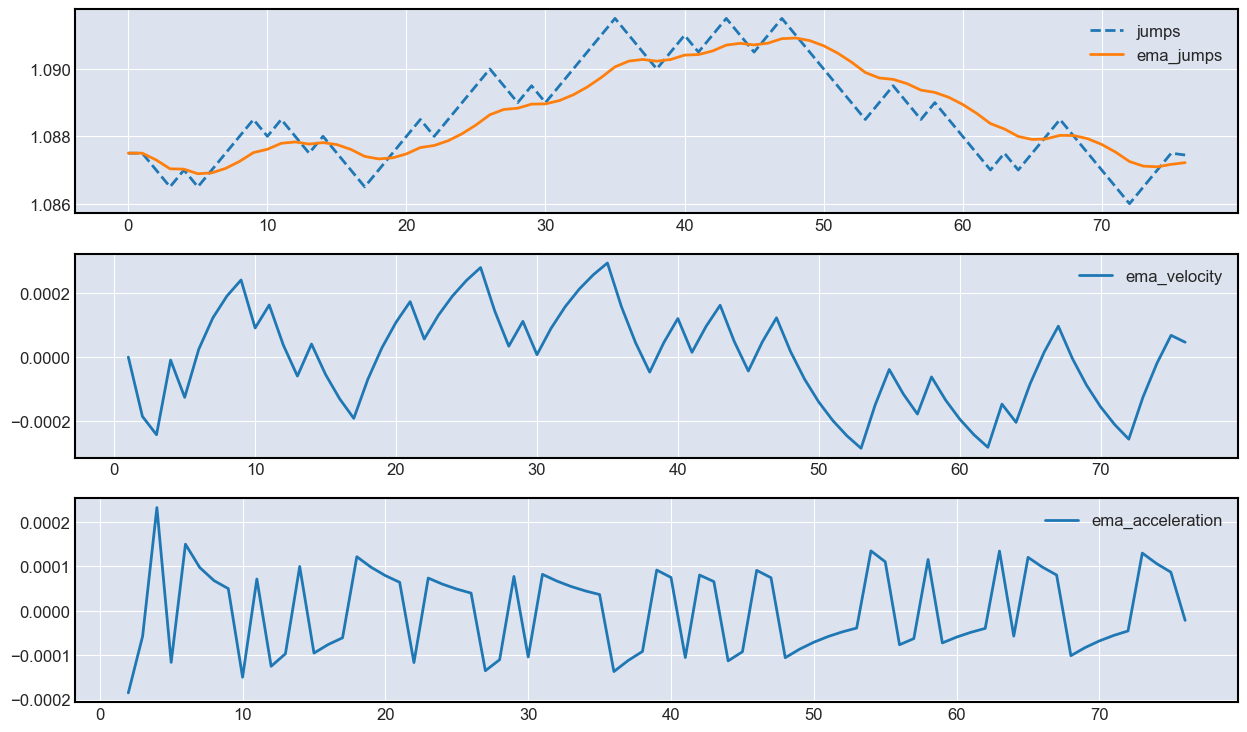

In [365]:
# Plot the results
fig,axs = plt.subplots(3,1,figsize=(15,9))
axs[0].plot(jumps.values, label='jumps', linestyle='--')
axs[0].plot(jump_ema.values, label='ema_jumps', linestyle='-')
#axs[0].plot(ladderized_data, label='Ladderized Data',alpha=0.5)
axs[0].legend()
axs[1].plot(velocity(jump_ema).values, label='ema_velocity')
axs[1].legend()
axs[2].plot(acceleration(jump_ema).values, label='ema_acceleration')
axs[2].legend()
plt.show() 

In [366]:
def convert_to_binomial(tick_data,grid_size,ladderized_function):
    ladderized_data = ladderized_function(tick_data,grid_size)
    jumps = filter_jumps(ladderized_data)
    binomial_data = jumps.diff()/grid_size
    binomial_data = np.vectorize(lambda x: float('{:.5g}'.format(x)))(binomial_data)
    return binomial_data[1:]

In [367]:
binomial_steps = convert_to_binomial(tick_data,0.0005,ladderize_absolute)

In [368]:
binomial_steps

array([ 0.     , -1.     , -1.     ,  1.     , -1.     ,  1.     ,
        1.     ,  1.     ,  1.     , -1.     ,  1.     , -1.     ,
       -1.     ,  1.     , -1.     , -1.     , -1.     ,  1.     ,
        1.     ,  1.     ,  1.     , -1.     ,  1.     ,  1.     ,
        1.     ,  1.     , -1.     , -1.     ,  1.     , -1.     ,
        1.     ,  1.     ,  1.     ,  1.     ,  1.     , -1.     ,
       -1.     , -1.     ,  1.     ,  1.     , -1.     ,  1.     ,
        1.     , -1.     , -1.     ,  1.     ,  1.     , -1.     ,
       -1.     , -1.     , -1.     , -1.     , -1.     ,  1.     ,
        1.     , -1.     , -1.     ,  1.     , -1.     , -1.     ,
       -1.     , -1.     ,  1.     , -1.     ,  1.     ,  1.     ,
        1.     , -1.     , -1.     , -1.     , -1.     , -1.     ,
        1.     ,  1.     ,  1.     , -0.10996])

## Strategy

In [369]:

grid_sizing = 0.0005
initial_position_sizing = 1000000
tick_data = dfb.get_tick_data('17 Aug 2023','18 Aug 2023')['EURUSD.mid']
binomial_steps = convert_to_binomial(tick_data,grid_sizing,ladderize_absolute)

2023-09-16 13:46:22,725 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-16 13:46:22,726 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-16 13:46:22,728 - findatapy.market.datavendorweb - INFO - Downloading... 2023-08-17 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2023/07/17/00h_ticks.bi5


2023-09-16 13:46:28,350 - findatapy.market.datavendorweb - INFO - Completed request from Dukascopy
2023-09-16 13:46:28,356 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_858__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_... to Redis: Error 61 connecting to 127.0.0.1:6379. Connection refused.


In [375]:
def build_position_sizing(initial_position_sizing,multiplier=1,indicator_data=[]):
    if len(indicator_data) == 0:
        return [initial_position_sizing * (multiplier**i) for i in range(len(binomial_steps))]
    else:
        return initial_position_sizing * indicator_data

In [386]:
def run_strategy_day(binomial_steps,grid_sizing,initial_position_sizing,multiplier=1,indicator_data=[],print_trade_book=False):
    PNL = np.zeros(len(binomial_steps))
    P = np.zeros(len(binomial_steps))
    position_sizing = build_position_sizing(initial_position_sizing,multiplier=1,indicator_data=indicator_data)
    for t in np.arange(0,len(binomial_steps)):
        P[t] = P[t-1] - position_sizing[t] * binomial_steps[t]
        PNL[t] = PNL[t-1] + P[t-1] * grid_sizing * binomial_steps[t]
        if print_trade_book:
            print('t = {}, binary_move={}, PNL = {},  Previous_position= {},current_postion = {}'.format(t,binomial_steps[t],PNL[t],P[t-1],P[t]))
    return PNL,P

In [388]:
PNL, P = run_strategy_day(binomial_steps,grid_sizing,initial_position_sizing,multiplier=1,indicator_data=[],print_trade_book=True)

t = 0, binary_move=0.0, PNL = 0.0,  Previous_position= 0.0,current_postion = 0.0
t = 1, binary_move=-1.0, PNL = 0.0,  Previous_position= 0.0,current_postion = 1000000.0
t = 2, binary_move=-1.0, PNL = -500.0,  Previous_position= 1000000.0,current_postion = 2000000.0
t = 3, binary_move=1.0, PNL = 500.0,  Previous_position= 2000000.0,current_postion = 1000000.0
t = 4, binary_move=-1.0, PNL = 0.0,  Previous_position= 1000000.0,current_postion = 2000000.0
t = 5, binary_move=1.0, PNL = 1000.0,  Previous_position= 2000000.0,current_postion = 1000000.0
t = 6, binary_move=1.0, PNL = 1500.0,  Previous_position= 1000000.0,current_postion = 0.0
t = 7, binary_move=1.0, PNL = 1500.0,  Previous_position= 0.0,current_postion = -1000000.0
t = 8, binary_move=1.0, PNL = 1000.0,  Previous_position= -1000000.0,current_postion = -2000000.0
t = 9, binary_move=-1.0, PNL = 2000.0,  Previous_position= -2000000.0,current_postion = -1000000.0
t = 10, binary_move=1.0, PNL = 1500.0,  Previous_position= -1000000.0,c

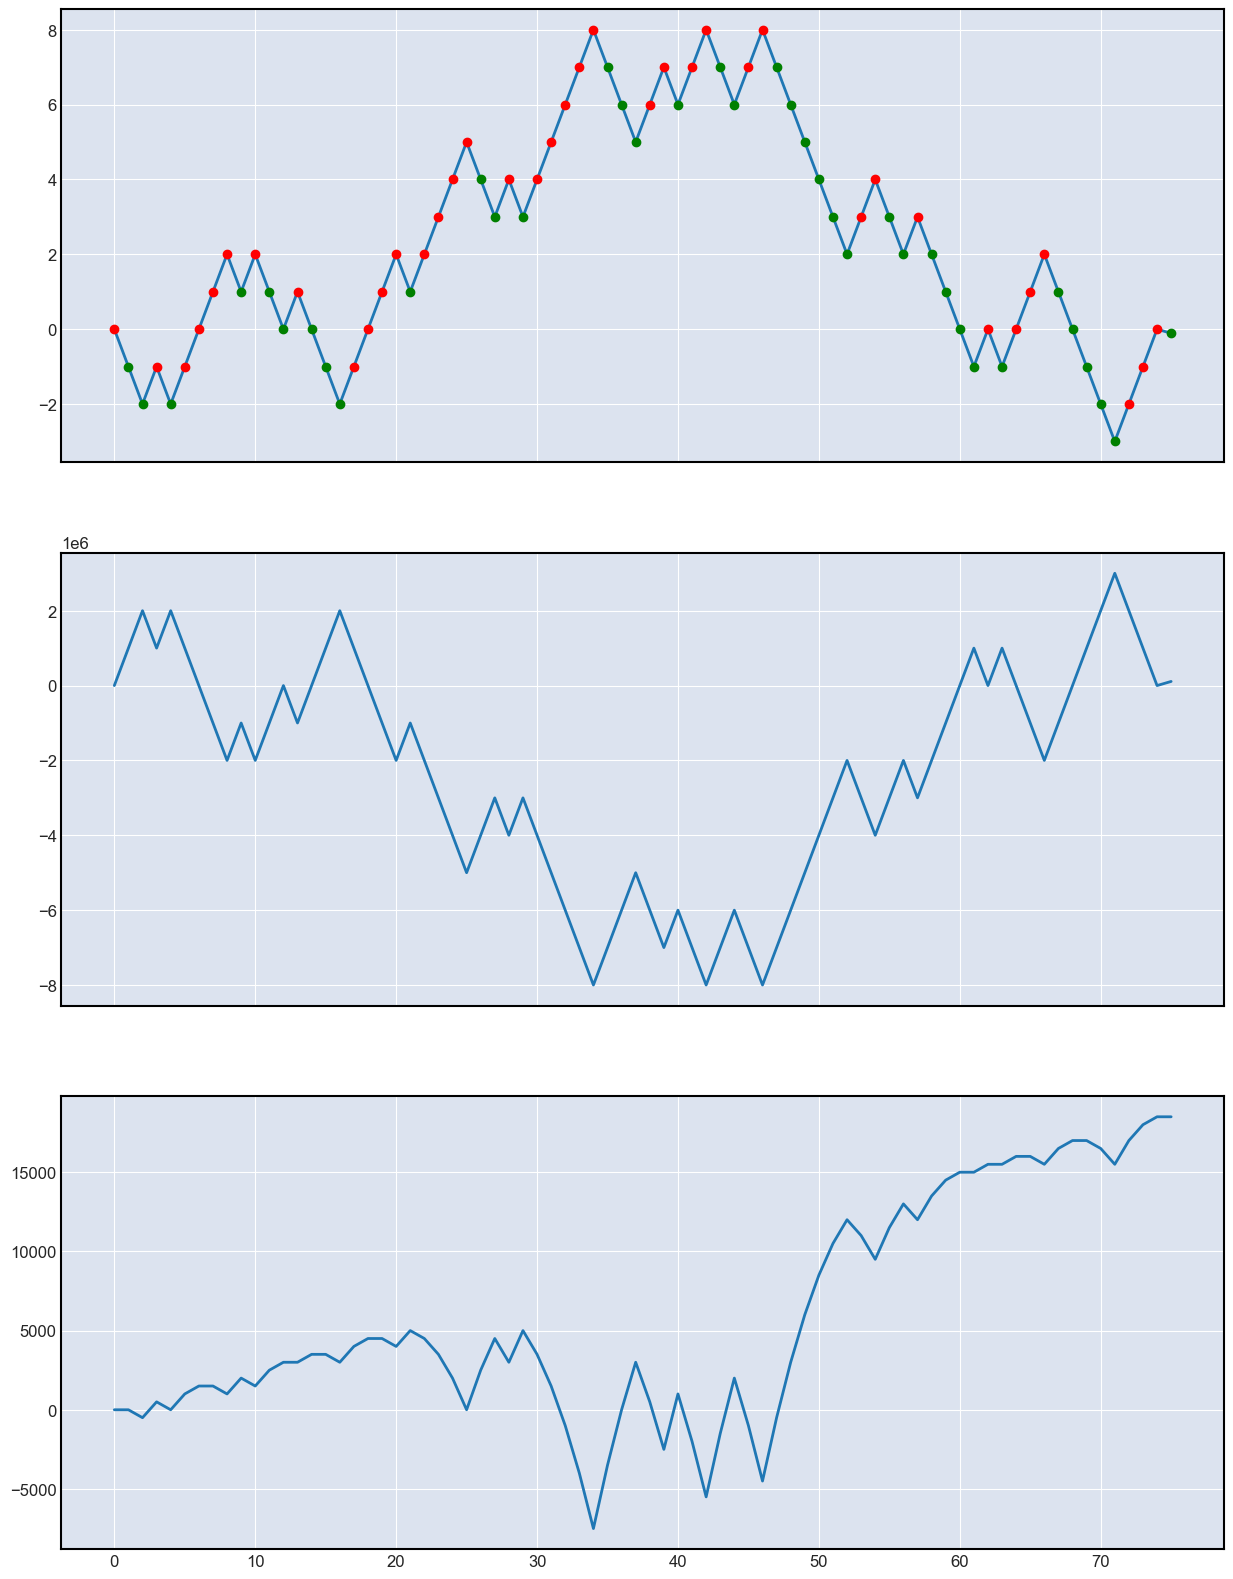

In [389]:
fig,axs = plt.subplots(3,1,figsize=(15,20),sharex=True)
cumulative_steps = np.cumsum(binomial_steps)
axs[0].plot(cumulative_steps)
for idx,i in enumerate(cumulative_steps):
    if cumulative_steps[idx] > cumulative_steps[idx-1]:
        axs[0].plot(idx, i , 'ro')  # Red point for upward movement
    else:
        axs[0].plot(idx, i, 'go')  # Blue point for downward movement
axs[1].plot(P)
axs[2].plot(PNL)
plt.show()